In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
from torch import nn

from utils import flat_to_triangular, make_cholesky, plot

np.random.seed(3)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def _npz(fn, *args, **kwargs):
    args = [t.cpu().detach().numpy() if isinstance(t, torch.Tensor) else t for t in args]
    kwargs = {k:t.cpu().detach().numpy() if isinstance(t, torch.Tensor) else t for k,t in kwargs.items()}
    return fn(*args, **kwargs)

### $D$-dimensional features, scalar regression target, with covariance, exact posterior


#### Dataset

f shape: torch.Size([40, 3])
a shape: torch.Size([3, 1])


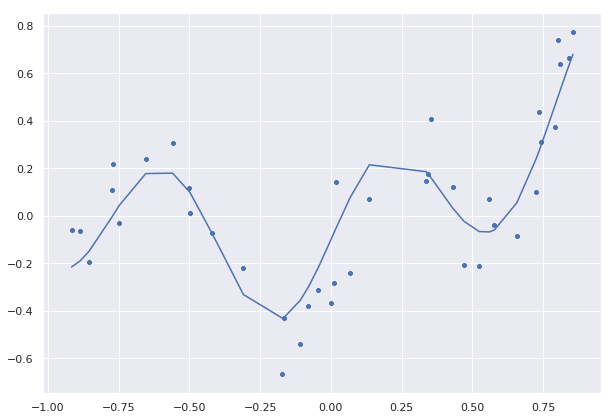

In [2]:
N_axis = 256
N = 40
true_a = torch.tensor([.3, .5, .3], device=device).view(-1, 1)
true_b = torch.tensor(0.2, device=device)
sigma = torch.tensor(0.15, device=device)  # observation noise
# x = np.linspace(-1, 1, N).reshape(-1, 1)

# create axis
x = torch.tensor((np.random.rand(N_axis) * 2 - 1).reshape(-1, 1), dtype=torch.float, device=device)
x,_ = torch.sort(x, dim=0)
fx1 = x - 1
fx2 = x**2
fx3 = torch.sin(8 * x)
x_axis = x
fx_axis = torch.cat((fx1, fx2, fx3), dim=-1)

# create data
x = torch.tensor((np.random.rand(N) * 2 - 1).reshape(-1, 1), dtype=torch.float, device=device)
x,_ = torch.sort(x, dim=0)
fx1 = x - 1
fx2 = x**2
fx3 = torch.sin(8 * x)
fx = torch.cat((fx1, fx2, fx3), dim=-1)
print('f shape:', fx.shape)
print('a shape:', true_a.shape)
t = fx @ true_a + true_b + sigma*torch.ones(x.shape, device=device).normal_()  # observations
plt.figure(figsize=(10, 7))

_npz(plt.plot, x, fx @ true_a + true_b)
# plt.plot(x, fx, alpha=0.3)
_npz(sns.scatterplot, x[:, 0], t[:, 0])
plt.show() 

#### Case 1: Known basis functions


In the case of known basis functions, the posterior is parametrized by the following:


\begin{align}
\Sigma = \left( I + \frac{1}{\sigma^2} f(x)^T f(x) \right)^{-1} \qquad \mu = \Sigma \frac{1}{\sigma^2} f(x)^T  t 
\end{align}

In [26]:
from torch.distributions import MultivariateNormal

class RegressionPosterior(MultivariateNormal):
    def __init__(self, fx, t, sigma):
        fx_ = self.get_basis(fx)
        I = torch.eye(fx_.shape[1], device=device)
        cov = torch.inverse(I + 1.0/sigma**2 * fx_.transpose(1,0) @ fx_)
        mu = 1.0 / sigma**2 * cov @ fx_.transpose(1,0) @ t
        super().__init__(mu.squeeze(), cov)
        self.sigma = sigma
        
    @staticmethod
    def get_basis(fx):
        return torch.cat([fx, torch.ones_like(fx[:,:1])], 1)
    
    def sample_weights(self, *args, **kwargs):
        weights = super().sample( *args, **kwargs)
        weights = weights.unsqueeze(-1)
        return weights
        
    def sample(self, fx, *args, **kwargs):
        weights = self.sample_weights(*args, **kwargs)
        fx_ = self.get_basis(fx)
        mean = fx_ @ weights
        return mean + self.sigma * torch.ones_like(mean).normal_()
    
    def plot_scatter(self, x, fx, n_samples=1):
        t_samples = self.sample(fx, (n_samples,))
        x = x.squeeze(-1).unsqueeze(0).expand(n_samples, -1,).contiguous()
        _npz(plt.scatter, x.view(-1), t_samples.view(-1), color='gray', alpha=0.3, label='Posterior sample')
        
    def plot_ci(self, x, fx, n_samples):
        t_samples = self.sample(fx, (n_samples,)).squeeze().cpu().data.numpy()
        x = x.squeeze().cpu().data.numpy()
        
        p = np.percentile(t_samples, [2.5,97.5], axis=0)
        plt.fill_between(x, p[0], p[1], alpha=0.2, label="95% CI")
        
        p = np.percentile(t_samples, [25,75], axis=0)
        plt.fill_between(x, p[0], p[1], alpha=0.2, label="50% CI")
        
        
    def plot(self, x, fx, n_samples=512):
        self.plot_scatter(x,fx,1)
        self.plot_ci(x, fx, n_samples)
        
        

In [27]:
posterior = RegressionPosterior(fx, t, sigma)

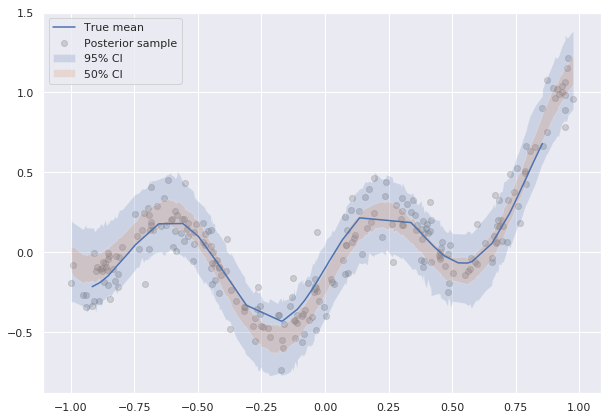

In [28]:
plt.figure(figsize=(10, 7))
_npz(plt.plot, x, fx @ true_a + true_b, label="True mean")
posterior.plot(x_axis,fx_axis)
plt.legend();plt.show()

#### Case 2: Learn the basis functions following the EM algorithm

In [33]:
class FeaturesExtractor(nn.Module):
    def __init__(self, n_out):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32), nn.ReLU(),
            nn.Linear(32, n_out))
        
    def forward(self, x):
        return self.layers(x)

In [34]:
features = FeaturesExtractor(n_out=true_a.shape[0])   # TODO use any n_out, not fixed to true parameter size
features.to(device)

l_rate = 0.01
epochs = 10000
n_samples = 3  # MC samples per example
maximization_freq = 100

logvar = nn.Parameter(torch.tensor(-1., device=device))  # for noise
optimiser = torch.optim.Adam(list(features.parameters()) + [logvar], lr = l_rate)

weights = None

for epoch in range(epochs):
    optimiser.zero_grad()
    
    # sigma
    sigma_ = torch.exp(0.5*logvar)
    
    # compute features
    h = features(x)
    
    if weights is None or epoch % maximization_freq == 0:
        # compute true posterior given the features
        posterior = RegressionPosterior(h, t, sigma_)
        
        # sample y
        weights = posterior.sample_weights((n_samples,)).detach()
        
    fx_ = posterior.get_basis(h)
    y_mean = fx_ @ weights
    y = y_mean + sigma_ * torch.ones_like(y_mean).normal_()

    # compute MSE
    expected_mse = (t.unsqueeze(0) - y)**2
    
    ## Reconstruction loss, estimated by MC
    recons = (0.5/logvar.exp() * expected_mse + 0.5*logvar)  # recons per example
    
    logp = - recons.sum(1) 
        
    logp = logp.mean() # log_sum_exp(elbo, dim=0, sum_op=torch.mean)
    
    loss = - logp
    loss.backward()
    optimiser.step()
    if epoch % 250 == 0 or epoch == epochs-1:
        print(f'epoch {epoch} : loss {loss.data.item():.3f} logp {logp.data.item():.3f}')
        

epoch 0 : loss 8.012 logp -8.012
epoch 250 : loss -29.772 logp 29.772
epoch 500 : loss -43.868 logp 43.868
epoch 750 : loss -34.212 logp 34.212
epoch 1000 : loss -35.878 logp 35.878
epoch 1250 : loss -40.814 logp 40.814
epoch 1500 : loss -40.573 logp 40.573
epoch 1750 : loss -42.827 logp 42.827
epoch 2000 : loss -45.985 logp 45.985
epoch 2250 : loss -45.315 logp 45.315
epoch 2500 : loss -47.583 logp 47.583
epoch 2750 : loss -47.299 logp 47.299
epoch 3000 : loss -43.793 logp 43.793
epoch 3250 : loss -46.428 logp 46.428
epoch 3500 : loss -48.028 logp 48.028
epoch 3750 : loss -54.751 logp 54.751
epoch 4000 : loss -44.560 logp 44.560
epoch 4250 : loss -48.140 logp 48.140
epoch 4500 : loss -40.142 logp 40.142
epoch 4750 : loss -49.539 logp 49.539
epoch 5000 : loss -47.059 logp 47.059
epoch 5250 : loss -48.258 logp 48.258
epoch 5500 : loss -45.379 logp 45.379
epoch 5750 : loss -37.075 logp 37.075
epoch 6000 : loss -52.289 logp 52.289
epoch 6250 : loss -41.361 logp 41.361
epoch 6500 : loss -4

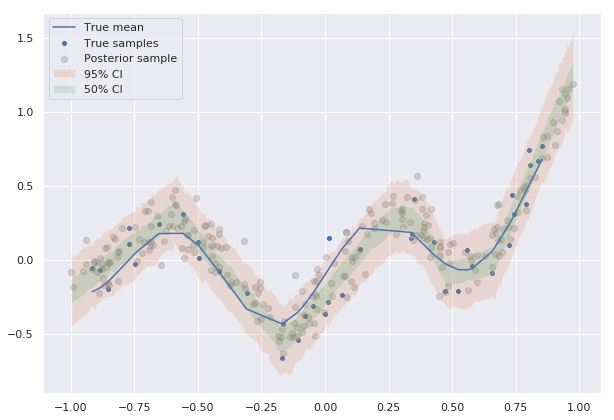

In [36]:
plt.figure(figsize=(10, 7))
_npz(plt.plot, x, fx @ true_a + true_b, label="True mean")
_npz(sns.scatterplot, x[:, 0], t[:, 0], label="True samples")
posterior.plot(x_axis,features(x_axis))
plt.legend();plt.show()